In [1]:
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

# ================= Load Dataset ================= #
iowa_file_path = '/kaggle/input/home-data-for-ml-course/train.csv'
home_data = pd.read_csv(iowa_file_path)
y = home_data.SalePrice
features = [col for col in home_data.columns if col not in ['SalePrice', 'Id']]
X = home_data[features]

# ================= Feature Preprocessing ================= #
categorical_features = [cname for cname in X.columns if X[cname].nunique() < 10 and X[cname].dtype == "object"]
numeric_features = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean'))])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# ================= Cross-Validation ================= #
kf = KFold(n_splits=5, shuffle=True, random_state=1)
fold_metrics = []

for fold_num, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    train_X, val_X = X.iloc[train_idx], X.iloc[val_idx]
    train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

    # Model pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=1,
            n_jobs=-1,
            tree_method='hist'
        ))
    ])
    
    model.fit(train_X, train_y)
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)

    # Compute metrics
    fold_metrics.append({
        "Train MAE": mean_absolute_error(train_y, pred_train),
        "Validation MAE": mean_absolute_error(val_y, pred_val),
        "Train MSE": mean_squared_error(train_y, pred_train),
        "Validation MSE": mean_squared_error(val_y, pred_val),
        "Train RMSE": np.sqrt(mean_squared_error(train_y, pred_train)),
        "Validation RMSE": np.sqrt(mean_squared_error(val_y, pred_val)),
        "Train RMSLE": np.sqrt(mean_squared_error(np.log1p(train_y), np.log1p(np.maximum(pred_train, 0)))),
        "Validation RMSLE": np.sqrt(mean_squared_error(np.log1p(val_y), np.log1p(np.maximum(pred_val, 0)))),
        "Train MAPE (%)": np.mean(np.abs((train_y - pred_train)/train_y))*100,
        "Validation MAPE (%)": np.mean(np.abs((val_y - pred_val)/val_y))*100,
        "Train R²": r2_score(train_y, pred_train),
        "Validation R²": r2_score(val_y, pred_val),
        "Train Median AE": median_absolute_error(train_y, pred_train),
        "Validation Median AE": median_absolute_error(val_y, pred_val)
    })

# ================= Convert to DataFrame with Fold as Index ================= #
Error_df = pd.DataFrame(fold_metrics, index=[f"Fold {i}" for i in range(1, 6)])
Error_df.index.name = "Fold"

# Add Average row
avg_row = Error_df.mean(numeric_only=True)
avg_row.name = "Average"
Error_df = pd.concat([Error_df, avg_row.to_frame().T])

# Format numbers
def format_number(x):
    if isinstance(x, (int, float, np.number)):
        return f"{x:.2e}" if abs(x) >= 1e5 else f"{x:.2f}"
    return x

Error_df = Error_df.map(format_number)

# Display
print("\n========= Cross-Validation Regression Metrics =========")
display(Error_df)



========= Cross-Validation Regression Metrics =========


,Train MAE,Validation MAE,Train MSE,Validation MSE,Train RMSE,Validation RMSE,Train RMSLE,Validation RMSLE,Train MAPE (%),Validation MAPE (%),Train R²,Validation R²,Train Median AE,Validation Median AE
Fold 1,687.99,15060.68,8.85e+05,7.30e+08,940.57,27025.20,0.01,0.13,0.44,9.16,1.00,0.90,514.50,9310.19
Fold 2,670.99,16071.55,8.41e+05,6.00e+08,917.30,24487.17,0.01,0.14,0.44,9.94,1.00,0.90,473.96,10757.16
Fold 3,669.21,16927.26,8.25e+05,7.36e+08,908.25,27130.38,0.01,0.12,0.44,9.04,1.00,0.87,491.60,10504.07
Fold 4,723.78,16742.74,1.02e+06,1.21e+09,1007.92,34830.13,0.01,0.13,0.48,8.98,1.00,0.82,510.32,10025.17
Fold 5,746.48,12813.51,1.05e+06,3.57e+08,1026.05,18895.40,0.01,0.10,0.49,7.46,1.00,0.94,513.02,9605.38
Average,699.69,15523.15,9.24e+05,7.27e+08,960.02,26473.66,0.01,0.13,0.46,8.92,1.00,0.89,500.68,10040.39


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


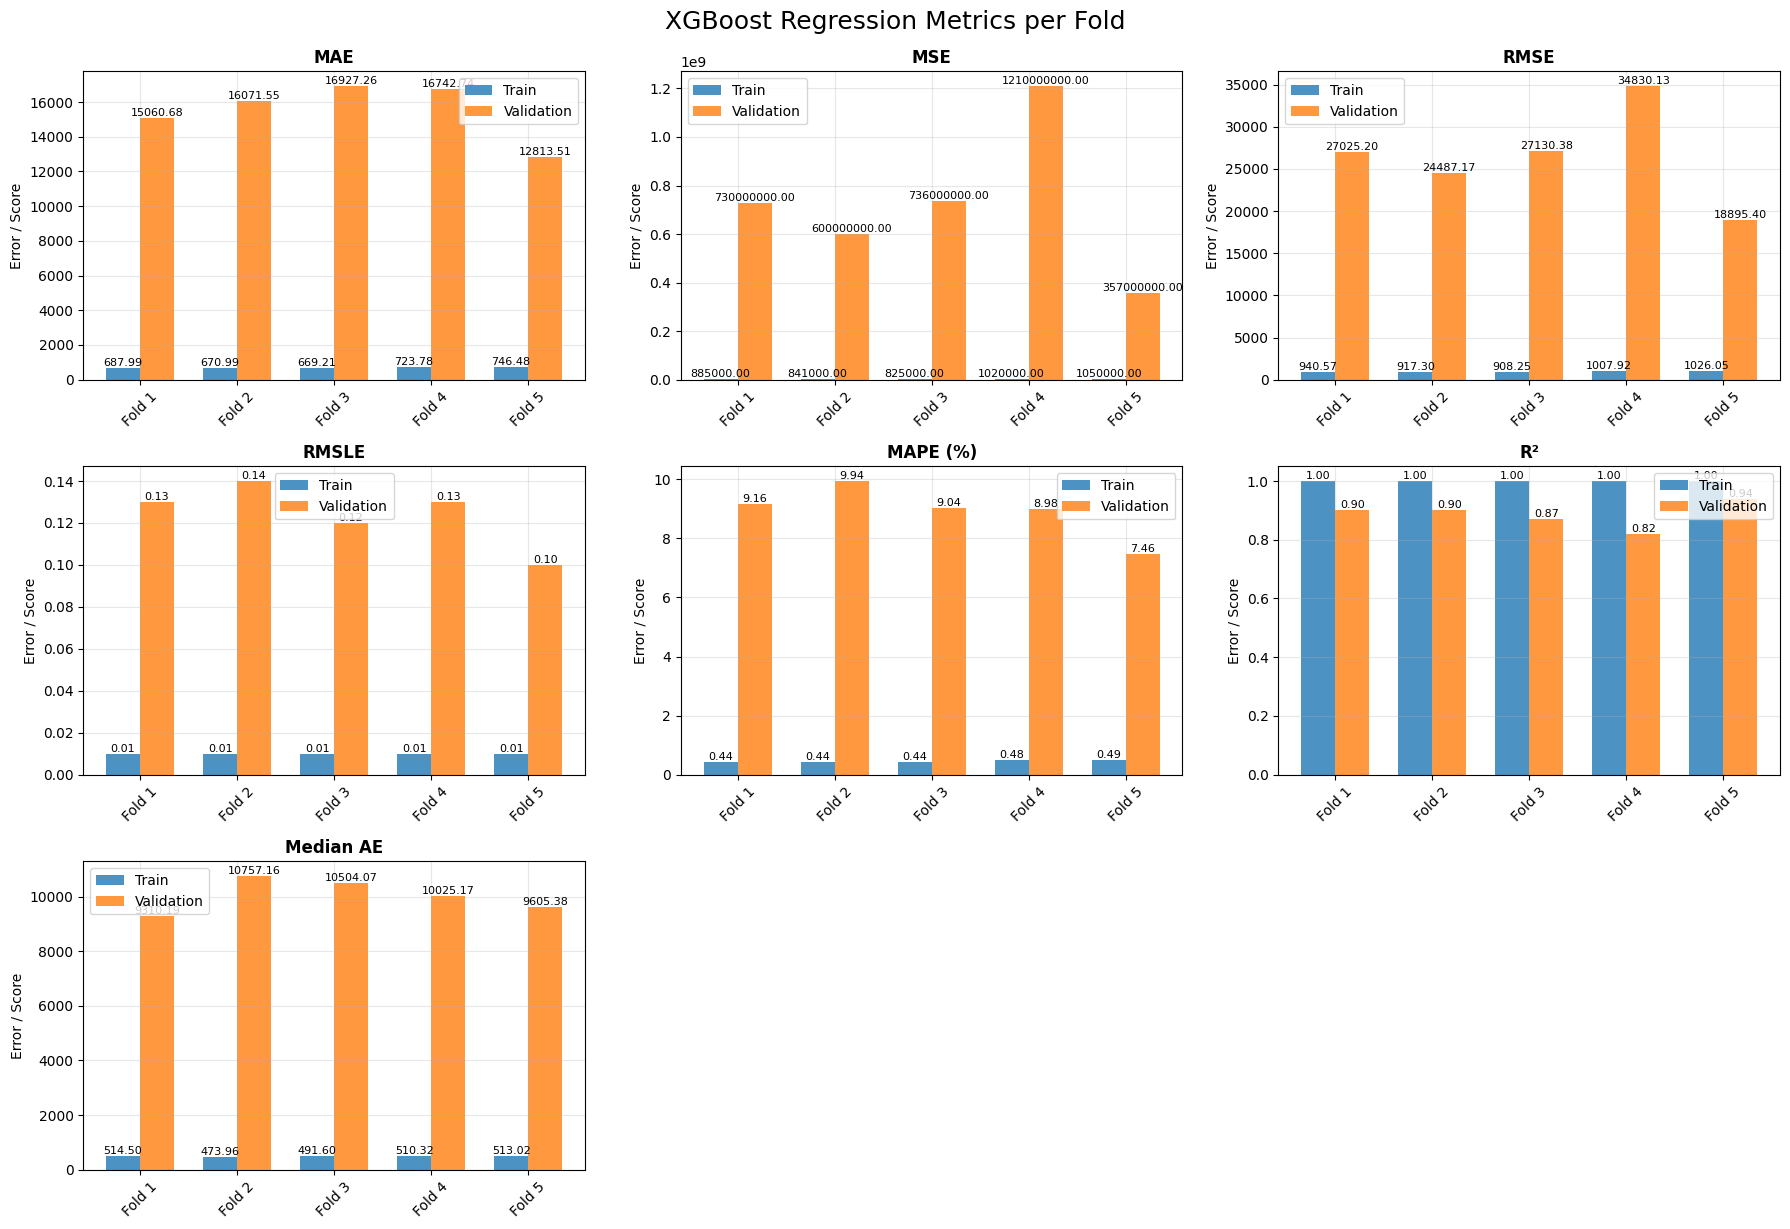

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Convert numeric columns back to float for plotting (exclude Average row)
plot_df = Error_df.drop("Average").astype(float)

# Metric pairs (Train vs Validation)
metric_pairs = [
    ("Train MAE", "Validation MAE"),
    ("Train MSE", "Validation MSE"),
    ("Train RMSE", "Validation RMSE"),
    ("Train RMSLE", "Validation RMSLE"),
    ("Train MAPE (%)", "Validation MAPE (%)"),
    ("Train R²", "Validation R²"),
    ("Train Median AE", "Validation Median AE")
]

# Plot layout
plt.figure(figsize=(18, 12))

for i, (train_m, val_m) in enumerate(metric_pairs):
    plt.subplot(3, 3, i+1)  # 3x3 grid
    
    x = np.arange(len(plot_df.index))
    width = 0.35
    
    # Bars for train and validation
    plt.bar(x - width/2, plot_df[train_m], width, label="Train", color="#1f77b4", alpha=0.8)
    plt.bar(x + width/2, plot_df[val_m], width, label="Validation", color="#ff7f0e", alpha=0.8)
    
    # Add values above bars
    for j in range(len(x)):
        plt.text(x[j] - width/2, plot_df[train_m].iloc[j], f"{plot_df[train_m].iloc[j]:.2f}", 
                 ha='center', va='bottom', fontsize=8, rotation=0)
        plt.text(x[j] + width/2, plot_df[val_m].iloc[j], f"{plot_df[val_m].iloc[j]:.2f}", 
                 ha='center', va='bottom', fontsize=8, rotation=0)

    plt.xticks(x, plot_df.index, rotation=45)
    plt.title(train_m.replace("Train ", ""), fontsize=12, weight='bold')
    plt.ylabel("Error / Score")
    plt.grid(alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.suptitle("XGBoost Regression Metrics per Fold", fontsize=18, y=1.02)

# Save plot
plt.savefig("/kaggle/working/XGBoost_Regression_Metrics.png", dpi=300, bbox_inches='tight')
plt.show()


In [4]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

# ==== Step 1: Define class conversion thresholds ====
p20, p40, p60, p80 = np.percentile(y, [20, 40, 60, 80])
class_labels = ["Too Low", "Low", "Medium", "High", "So High"]

def price_to_class(prices):
    classes = np.zeros_like(prices, dtype=int)
    classes[(prices >= p20) & (prices < p40)] = 1
    classes[(prices >= p40) & (prices < p60)] = 2
    classes[(prices >= p60) & (prices < p80)] = 3
    classes[(prices >= p80)] = 4
    return classes

# ==== Step 2: Cross-validation ====
val_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    train_X, val_X = X.iloc[train_idx], X.iloc[val_idx]
    train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

    # XGBoost Model Pipeline
    model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=1,
            n_jobs=-1,
            tree_method='hist'
        ))
    ])
    
    model.fit(train_X, train_y)
    
    # Predictions
    pred_train = model.predict(train_X)
    pred_val = model.predict(val_X)

    # Convert regression to class categories
    train_y_class, val_y_class = price_to_class(train_y), price_to_class(val_y)
    pred_train_class, pred_val_class = price_to_class(pred_train), price_to_class(pred_val)

    # Accuracy
    train_acc = accuracy_score(train_y_class, pred_train_class) * 100
    val_acc = accuracy_score(val_y_class, pred_val_class) * 100
    val_accuracies.append(val_acc)

    # Confusion matrix
    cm = confusion_matrix(val_y_class, pred_val_class)
    cm_df = pd.DataFrame(cm, index=[f"Actual {lbl}" for lbl in class_labels],
                            columns=[f"Pred {lbl}" for lbl in class_labels])

    # Per-class metrics
    precision = precision_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100
    recall = recall_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100
    f1 = f1_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100

    Performance_df = pd.DataFrame({
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1
    }, index=[x for x in class_labels])
    Performance_df.index.name = "Class"

    # Format the performance dataframe
    Performance_df = Performance_df.map(lambda x: f"{x:.2f}" if isinstance(x, (int, float, np.number)) else x)

    # ==== Step 3: Display results per fold ====
    print(f"\n================ Fold {fold} Results (XGBoost) ================")
    print(f"Training Accuracy: {train_acc:.2f}%")
    print(f"Validation Accuracy: {val_acc:.2f}%\n")

    print("Confusion Matrix:")
    display(cm_df)

    print("\nClassification Metrics per Class:\n")
    display(Performance_df)

# ==== Step 4: Print Average Validation Accuracy ====
print(f"\nAverage Validation Accuracy (XGBoost): {np.mean(val_accuracies):.2f}%")
print(f"Standard Deviation: {np.std(val_accuracies):.2f}%")


================ Fold 1 Results (XGBoost) ================
Training Accuracy: 97.77%
Validation Accuracy: 74.32%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,60,12,0,0,0
Actual Low,14,36,7,1,0
Actual Medium,1,10,39,10,0
Actual High,0,0,13,32,4
Actual So High,0,0,0,3,50



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,80.00,83.33,81.63
Low,62.07,62.07,62.07
Medium,66.10,65.00,65.55
High,69.57,65.31,67.37
So High,92.59,94.34,93.46



================ Fold 2 Results (XGBoost) ================
Training Accuracy: 98.03%
Validation Accuracy: 72.95%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,45,9,3,1,0
Actual Low,8,40,12,2,0
Actual Medium,1,6,33,11,1
Actual High,0,0,10,36,9
Actual So High,0,0,0,6,59



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,83.33,77.59,80.36
Low,72.73,64.52,68.38
Medium,56.90,63.46,60.00
High,64.29,65.45,64.86
So High,85.51,90.77,88.06



================ Fold 3 Results (XGBoost) ================
Training Accuracy: 98.03%
Validation Accuracy: 68.84%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,39,10,1,0,0
Actual Low,11,30,12,0,0
Actual Medium,0,15,37,11,1
Actual High,0,0,8,47,7
Actual So High,0,0,0,15,48



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,78.00,78.00,78.00
Low,54.55,56.60,55.56
Medium,63.79,57.81,60.66
High,64.38,75.81,69.63
So High,85.71,76.19,80.67



================ Fold 4 Results (XGBoost) ================
Training Accuracy: 97.86%
Validation Accuracy: 74.32%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,43,9,1,0,0
Actual Low,5,41,13,2,0
Actual Medium,1,19,34,7,0
Actual High,0,1,5,49,5
Actual So High,0,0,0,7,50



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,87.76,81.13,84.31
Low,58.57,67.21,62.60
Medium,64.15,55.74,59.65
High,75.38,81.67,78.40
So High,90.91,87.72,89.29



================ Fold 5 Results (XGBoost) ================
Training Accuracy: 97.77%
Validation Accuracy: 77.74%

Confusion Matrix:


,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
Actual Too Low,47,8,1,0,0
Actual Low,8,39,8,2,0
Actual Medium,1,8,43,7,0
Actual High,0,0,7,48,6
Actual So High,0,0,0,9,50



Classification Metrics per Class:



,Precision (%),Recall (%),F1-Score (%)
Class,,,
Too Low,83.93,83.93,83.93
Low,70.91,68.42,69.64
Medium,72.88,72.88,72.88
High,72.73,78.69,75.59
So High,89.29,84.75,86.96



Average Validation Accuracy (XGBoost): 73.63%
Standard Deviation: 2.87%


In [5]:
# Class thresholds
p20, p40, p60, p80 = np.percentile(y, [20, 40, 60, 80])
class_labels = ["Too Low", "Low", "Medium", "High", "So High"]

def price_to_class(prices):
    classes = np.zeros_like(prices, dtype=int)
    classes[(prices >= p20) & (prices < p40)] = 1
    classes[(prices >= p40) & (prices < p60)] = 2
    classes[(prices >= p60) & (prices < p80)] = 3
    classes[(prices >= p80)] = 4
    return classes

# Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Store metrics
fold_class_metrics = []
fold_accuracy = []
fold_confusion = []

   # XGBoost Model Pipeline
model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=1,
            n_jobs=-1,
            tree_method='hist'
        ))
    ])

for fold, (train_idx, val_idx) in enumerate(kf.split(X), 1):
    train_X, val_X = X.iloc[train_idx], X.iloc[val_idx]
    train_y, val_y = y.iloc[train_idx], y.iloc[val_idx]

 
    
    model.fit(train_X, train_y)
    pred_train, pred_val = model.predict(train_X), model.predict(val_X)

    # Class conversion
    train_y_class, val_y_class = price_to_class(train_y), price_to_class(val_y)
    pred_train_class, pred_val_class = price_to_class(pred_train), price_to_class(pred_val)

    # Accuracy per fold
    train_acc = accuracy_score(train_y_class, pred_train_class) * 100
    val_acc = accuracy_score(val_y_class, pred_val_class) * 100
    fold_accuracy.append({"Fold": fold, "Training Accuracy (%)": train_acc, "Validation Accuracy (%)": val_acc})

    # Class metrics
    precision = precision_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100
    recall = recall_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100
    f1 = f1_score(val_y_class, pred_val_class, average=None, zero_division=0) * 100

    class_metrics_df = pd.DataFrame({
        "Fold": fold,
        "Class": class_labels,
        "Precision (%)": precision,
        "Recall (%)": recall,
        "F1-Score (%)": f1
    })
    fold_class_metrics.append(class_metrics_df)

    # Confusion matrix
    cm = confusion_matrix(val_y_class, pred_val_class)
    cm_df = pd.DataFrame(cm, index=[f"Actual {lbl}" for lbl in class_labels],
                         columns=[f"Pred {lbl}" for lbl in class_labels])
    cm_df.insert(0, "Fold", fold)
    cm_df = cm_df.reset_index().rename(columns={"index": "Actual Class"})
    fold_confusion.append(cm_df)

# ===== Combine DataFrames =====
# Class metrics
Performance_df = pd.concat(fold_class_metrics, ignore_index=True)
avg_metrics = Performance_df.groupby("Class")[["Precision (%)", "Recall (%)", "F1-Score (%)"]].mean().reset_index()
avg_metrics.insert(0, "Fold", "Average")
Performance_df = pd.concat([Performance_df, avg_metrics], ignore_index=True)
Performance_df[["Precision (%)", "Recall (%)", "F1-Score (%)"]] = \
    Performance_df[["Precision (%)", "Recall (%)", "F1-Score (%)"]].map(lambda x: f"{x:.2f}" if isinstance(x,(int,float,np.number)) else x)

# Accuracy metrics
Accuracy_df = pd.DataFrame(fold_accuracy)
avg_acc = Accuracy_df[["Training Accuracy (%)","Validation Accuracy (%)"]].mean()
avg_acc_row = {"Fold":"Average","Training Accuracy (%)":avg_acc["Training Accuracy (%)"],"Validation Accuracy (%)":avg_acc["Validation Accuracy (%)"]}
Accuracy_df = pd.concat([Accuracy_df, pd.DataFrame([avg_acc_row])], ignore_index=True)
Accuracy_df[["Training Accuracy (%)","Validation Accuracy (%)"]] = Accuracy_df[["Training Accuracy (%)","Validation Accuracy (%)"]].map(lambda x: f"{x:.2f}" if isinstance(x,(int,float,np.number)) else x)

# Confusion matrix for all folds
Confusion_df = pd.concat(fold_confusion, ignore_index=True)

# ===== Display =====
print("\n" + "="*60)
print("XGBOOST REGRESSOR - CLASSIFICATION-STYLE EVALUATION")
print("="*60)

print("\n=== Confusion Matrices Per Fold ===")
display(Confusion_df)

print("=== Per-Class Metrics Across Folds ===")
display(Performance_df)

print("\n=== Training & Validation Accuracy Per Fold ===")
display(Accuracy_df)

# ===== Additional Summary Statistics =====
print("\n" + "="*50)
print("OVERALL PERFORMANCE SUMMARY (XGBoost)")
print("="*50)
print(f"Average Training Accuracy: {Accuracy_df[Accuracy_df['Fold'] != 'Average']['Training Accuracy (%)'].astype(float).mean():.2f}%")
print(f"Average Validation Accuracy: {Accuracy_df[Accuracy_df['Fold'] != 'Average']['Validation Accuracy (%)'].astype(float).mean():.2f}%")
print(f"Validation Accuracy Std: {Accuracy_df[Accuracy_df['Fold'] != 'Average']['Validation Accuracy (%)'].astype(float).std():.2f}%")

# Show price ranges for each class
print(f"\nPrice Class Ranges:")
print(f"  Too Low:  < ${p20:,.0f}")
print(f"  Low:      ${p20:,.0f} - ${p40:,.0f}")
print(f"  Medium:   ${p40:,.0f} - ${p60:,.0f}")
print(f"  High:     ${p60:,.0f} - ${p80:,.0f}")
print(f"  So High:  >= ${p80:,.0f}")

# Optional: Save CSVs
# Performance_df.to_csv("/kaggle/working/XGBoost_Performance_PerClass.csv", index=False)
# Accuracy_df.to_csv("/kaggle/working/XGBoost_Accuracy_PerFold.csv", index=False)
Confusion_df.to_csv("/kaggle/working/XGBoost_Confusion_PerFold.csv", index=False)



XGBOOST REGRESSOR - CLASSIFICATION-STYLE EVALUATION

=== Confusion Matrices Per Fold ===


,Actual Class,Fold,Pred Too Low,Pred Low,Pred Medium,Pred High,Pred So High
0,Actual Too Low,1,60,12,0,0,0
1,Actual Low,1,14,36,7,1,0
2,Actual Medium,1,1,10,39,10,0
3,Actual High,1,0,0,13,32,4
4,Actual So High,1,0,0,0,3,50
5,Actual Too Low,2,45,9,3,1,0
6,Actual Low,2,8,40,12,2,0
7,Actual Medium,2,1,6,33,11,1
8,Actual High,2,0,0,10,36,9
9,Actual So High,2,0,0,0,6,59


=== Per-Class Metrics Across Folds ===


,Fold,Class,Precision (%),Recall (%),F1-Score (%)
0,1,Too Low,80.00,83.33,81.63
1,1,Low,62.07,62.07,62.07
2,1,Medium,66.10,65.00,65.55
3,1,High,69.57,65.31,67.37
4,1,So High,92.59,94.34,93.46
5,2,Too Low,83.33,77.59,80.36
6,2,Low,72.73,64.52,68.38
7,2,Medium,56.90,63.46,60.00
8,2,High,64.29,65.45,64.86
9,2,So High,85.51,90.77,88.06



=== Training & Validation Accuracy Per Fold ===


,Fold,Training Accuracy (%),Validation Accuracy (%)
0,1,97.77,74.32
1,2,98.03,72.95
2,3,98.03,68.84
3,4,97.86,74.32
4,5,97.77,77.74
5,Average,97.89,73.63



OVERALL PERFORMANCE SUMMARY (XGBoost)
Average Training Accuracy: 97.89%
Average Validation Accuracy: 73.63%
Validation Accuracy Std: 3.21%

Price Class Ranges:
  Too Low:  < $124,000
  Low:      $124,000 - $147,000
  Medium:   $147,000 - $179,280
  High:     $179,280 - $230,000
  So High:  >= $230,000


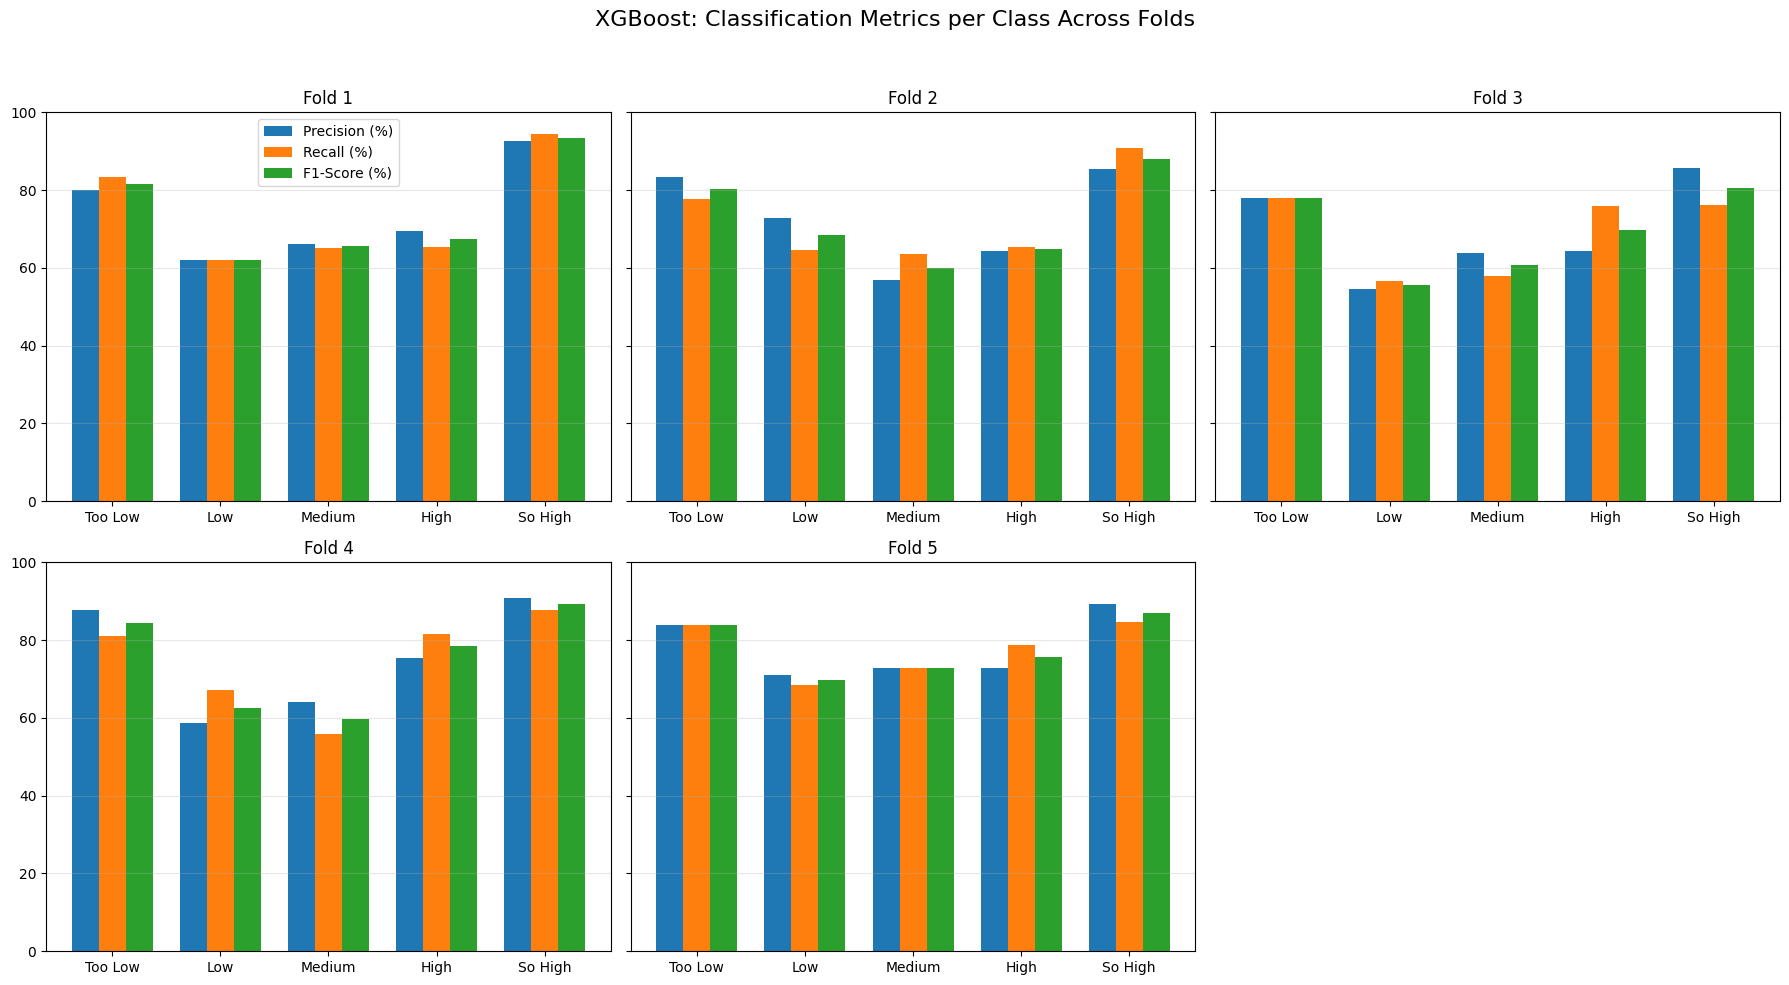

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
plot_df = Performance_df[Performance_df["Fold"] != "Average"].copy()
plot_df[["Precision (%)","Recall (%)","F1-Score (%)"]] = \
    plot_df[["Precision (%)","Recall (%)","F1-Score (%)"]].astype(float)

folds = sorted(plot_df["Fold"].unique())
classes = ["Too Low", "Low", "Medium", "High", "So High"]
metrics = ["Precision (%)", "Recall (%)", "F1-Score (%)"]
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Subplots: 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18,10), sharey=True)
axes = axes.flatten()

for i, fold in enumerate(folds):
    ax = axes[i]
    fold_data = plot_df[plot_df["Fold"] == fold]
    x = np.arange(len(classes))
    
    for j, metric in enumerate(metrics):
        ax.bar(x + j*0.25, fold_data[metric], width=0.25, color=colors[j], label=metric if i==0 else "")
    
    ax.set_title(f"Fold {fold}")
    ax.set_xticks(x + 0.25)
    ax.set_xticklabels(classes)
    ax.set_ylim(0, 100)
    ax.grid(axis='y', alpha=0.3)
    if i==0:
        ax.legend()

# Remove empty subplot if folds < number of axes
for k in range(len(folds), len(axes)):
    fig.delaxes(axes[k])

fig.suptitle("XGBoost: Classification Metrics per Class Across Folds", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
plt.savefig("/kaggle/working/XGBoost_Performance_per_plot.png", dpi=300)
plt.show()

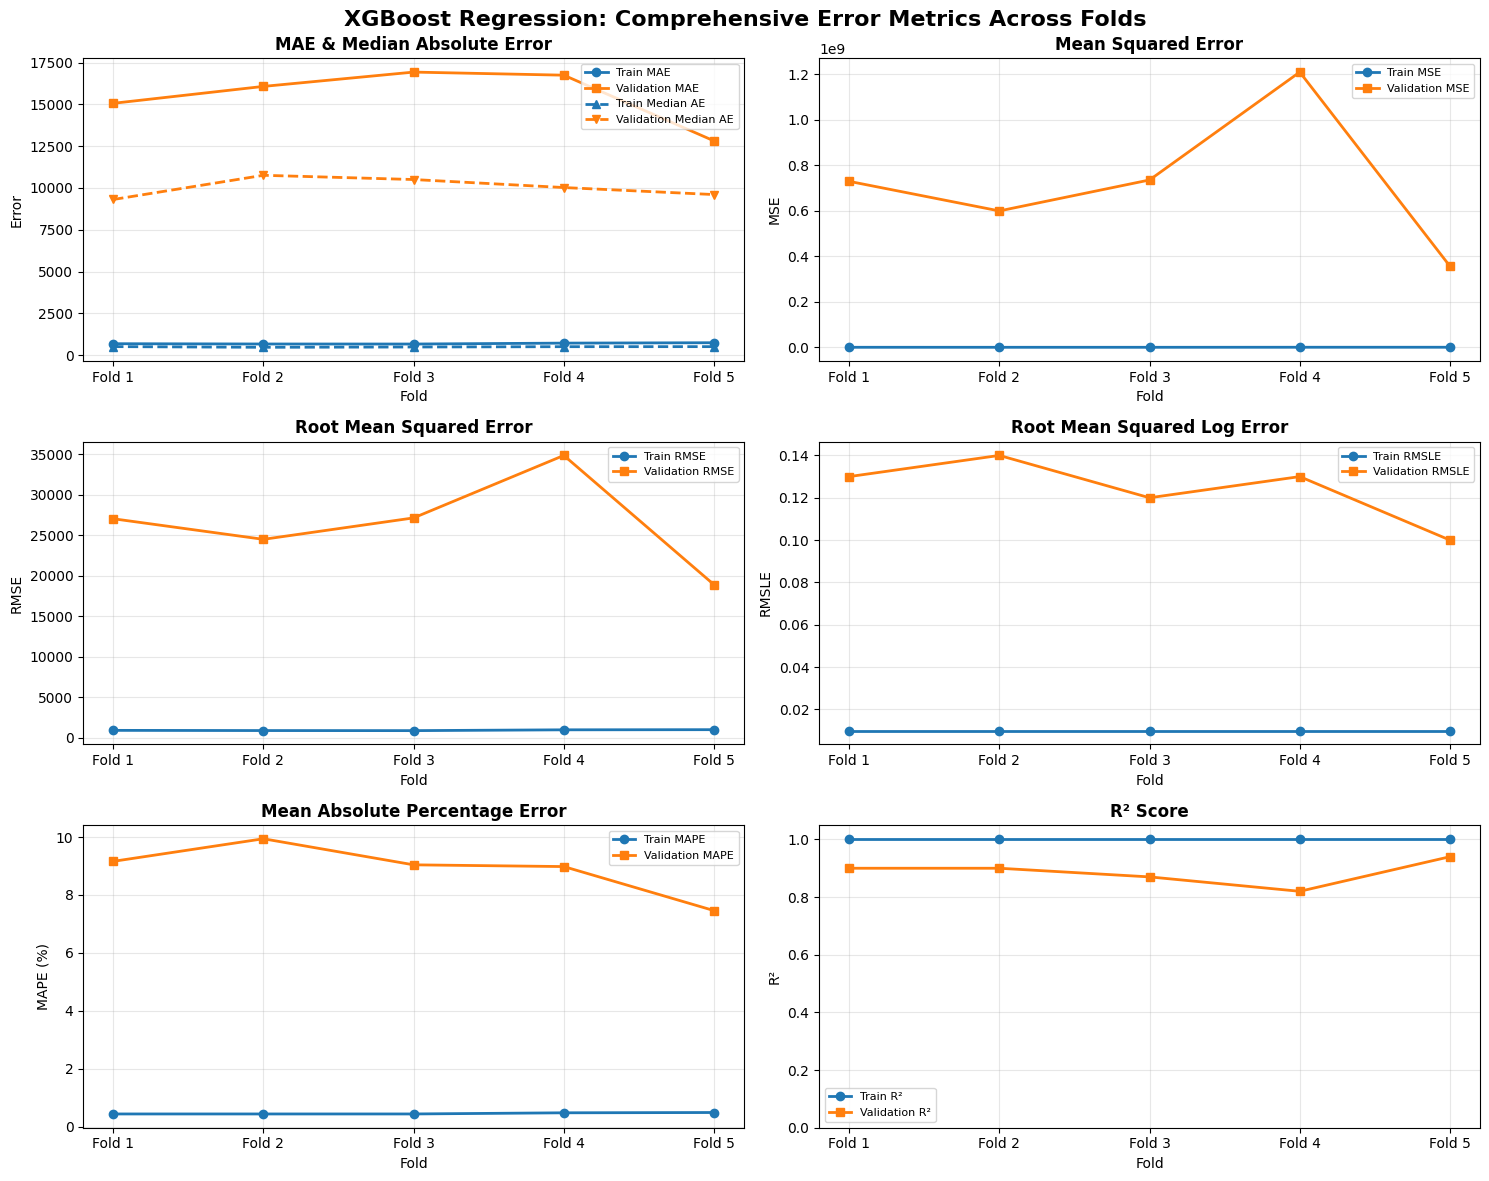

In [7]:
import matplotlib.pyplot as plt

# Convert all numeric columns back to float for plotting
Error_df_plot = Error_df.copy()
numeric_columns = ["Train MAE", "Validation MAE", "Train MSE", "Validation MSE", 
                   "Train RMSE", "Validation RMSE", "Train RMSLE", "Validation RMSLE",
                   "Train MAPE (%)", "Validation MAPE (%)", "Train R²", "Validation R²",
                   "Train Median AE", "Validation Median AE"]

for col in numeric_columns:
    Error_df_plot[col] = Error_df_plot[col].astype(float)

# Exclude Average row for fold-wise plot
fold_df = Error_df_plot[Error_df_plot.index != "Average"]

# Create subplots: 3 rows x 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 12))

# Flatten axes for easy indexing
axes = axes.flatten()

# Plot 1: MAE and Median AE
axes[0].plot(fold_df.index, fold_df["Train MAE"], marker='o', label="Train MAE", color="#1f77b4", linewidth=2)
axes[0].plot(fold_df.index, fold_df["Validation MAE"], marker='s', label="Validation MAE", color="#ff7f0e", linewidth=2)
axes[0].plot(fold_df.index, fold_df["Train Median AE"], marker='^', label="Train Median AE", color="#1f77b4", linestyle='--', linewidth=2)
axes[0].plot(fold_df.index, fold_df["Validation Median AE"], marker='v', label="Validation Median AE", color="#ff7f0e", linestyle='--', linewidth=2)
axes[0].set_title("MAE & Median Absolute Error", fontsize=12, weight='bold')
axes[0].set_ylabel("Error", fontsize=10)
axes[0].grid(alpha=0.3)
axes[0].legend(fontsize=8)

# Plot 2: MSE
axes[1].plot(fold_df.index, fold_df["Train MSE"], marker='o', label="Train MSE", color="#1f77b4", linewidth=2)
axes[1].plot(fold_df.index, fold_df["Validation MSE"], marker='s', label="Validation MSE", color="#ff7f0e", linewidth=2)
axes[1].set_title("Mean Squared Error", fontsize=12, weight='bold')
axes[1].set_ylabel("MSE", fontsize=10)
axes[1].grid(alpha=0.3)
axes[1].legend(fontsize=8)

# Plot 3: RMSE
axes[2].plot(fold_df.index, fold_df["Train RMSE"], marker='o', label="Train RMSE", color="#1f77b4", linewidth=2)
axes[2].plot(fold_df.index, fold_df["Validation RMSE"], marker='s', label="Validation RMSE", color="#ff7f0e", linewidth=2)
axes[2].set_title("Root Mean Squared Error", fontsize=12, weight='bold')
axes[2].set_ylabel("RMSE", fontsize=10)
axes[2].grid(alpha=0.3)
axes[2].legend(fontsize=8)

# Plot 4: RMSLE
axes[3].plot(fold_df.index, fold_df["Train RMSLE"], marker='o', label="Train RMSLE", color="#1f77b4", linewidth=2)
axes[3].plot(fold_df.index, fold_df["Validation RMSLE"], marker='s', label="Validation RMSLE", color="#ff7f0e", linewidth=2)
axes[3].set_title("Root Mean Squared Log Error", fontsize=12, weight='bold')
axes[3].set_ylabel("RMSLE", fontsize=10)
axes[3].grid(alpha=0.3)
axes[3].legend(fontsize=8)

# Plot 5: MAPE
axes[4].plot(fold_df.index, fold_df["Train MAPE (%)"], marker='o', label="Train MAPE", color="#1f77b4", linewidth=2)
axes[4].plot(fold_df.index, fold_df["Validation MAPE (%)"], marker='s', label="Validation MAPE", color="#ff7f0e", linewidth=2)
axes[4].set_title("Mean Absolute Percentage Error", fontsize=12, weight='bold')
axes[4].set_ylabel("MAPE (%)", fontsize=10)
axes[4].grid(alpha=0.3)
axes[4].legend(fontsize=8)

# Plot 6: R²
axes[5].plot(fold_df.index, fold_df["Train R²"], marker='o', label="Train R²", color="#1f77b4", linewidth=2)
axes[5].plot(fold_df.index, fold_df["Validation R²"], marker='s', label="Validation R²", color="#ff7f0e", linewidth=2)
axes[5].set_title("R² Score", fontsize=12, weight='bold')
axes[5].set_ylabel("R²", fontsize=10)
axes[5].set_ylim(0, 1.05)
axes[5].grid(alpha=0.3)
axes[5].legend(fontsize=8)

# Set common x-label
for ax in axes:
    ax.set_xlabel("Fold", fontsize=10)

# Main title
plt.suptitle("XGBoost Regression: Comprehensive Error Metrics Across Folds", 
             fontsize=16, weight='bold', y=0.98)

plt.tight_layout()

# Save the plot
plt.savefig("/kaggle/working/XGBoost_all_error_metrics_per_fold.png", dpi=300, bbox_inches='tight')
plt.show()